# Identify spikes
Develop algorithm for identifying spikes (action potential-like activity)

## Set-up

### Imports

In [26]:
# imports - general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# imports - custom
import sys
sys.path.append("../code")
from info import FS, N_CHANNELS#, N_SPECIES
from epoch_extraction_tools import get_epochs, plot_epochs, get_epoch_times

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Main

### Load data

In [103]:
# load example file
i_file = 1

# import
path = '../../../datasets/adamatzky_2021/txt'
files = os.listdir(path)
print(f"Importing: {files[i_file]}")
data = pd.read_csv(os.path.join(path, files[i_file]), sep='\t')

# interpolate nan
data = data.interpolate(method='linear', axis=0)
data

Importing: enoki_fungi_flammulina_velutipes.txt


,Differential 1 - 2 Ave. (mV),Differential 3 - 4 Ave. (mV),Differential 5 - 6 Ave. (mV),Differential 7 - 8 Ave. (mV),Differential 9 - 10 Ave. (mV),Differential 11 - 12 Ave. (mV),Differential 13 - 14 Ave. (mV)
0,1.262,0.263,2.271,7.618,0.144,0.368,-0.086
1,-0.163,-1.173,-0.124,7.624,-0.035,0.374,-0.047
2,-0.160,0.446,2.204,7.605,-0.069,0.357,0.010
3,1.160,-1.176,-0.131,6.295,-1.388,3.167,0.060
4,-0.157,0.409,2.202,7.498,0.316,0.334,0.114
...,...,...,...,...,...,...,...
1210933,0.594,0.230,-1.925,-7.736,-0.476,1.695,-0.454
1210934,0.594,0.230,-1.925,-7.736,-0.476,1.695,-0.454
1210935,0.594,0.230,-1.925,-7.736,-0.476,1.695,-0.454
1210936,0.594,0.230,-1.925,-7.736,-0.476,1.695,-0.454


### Plot time-series

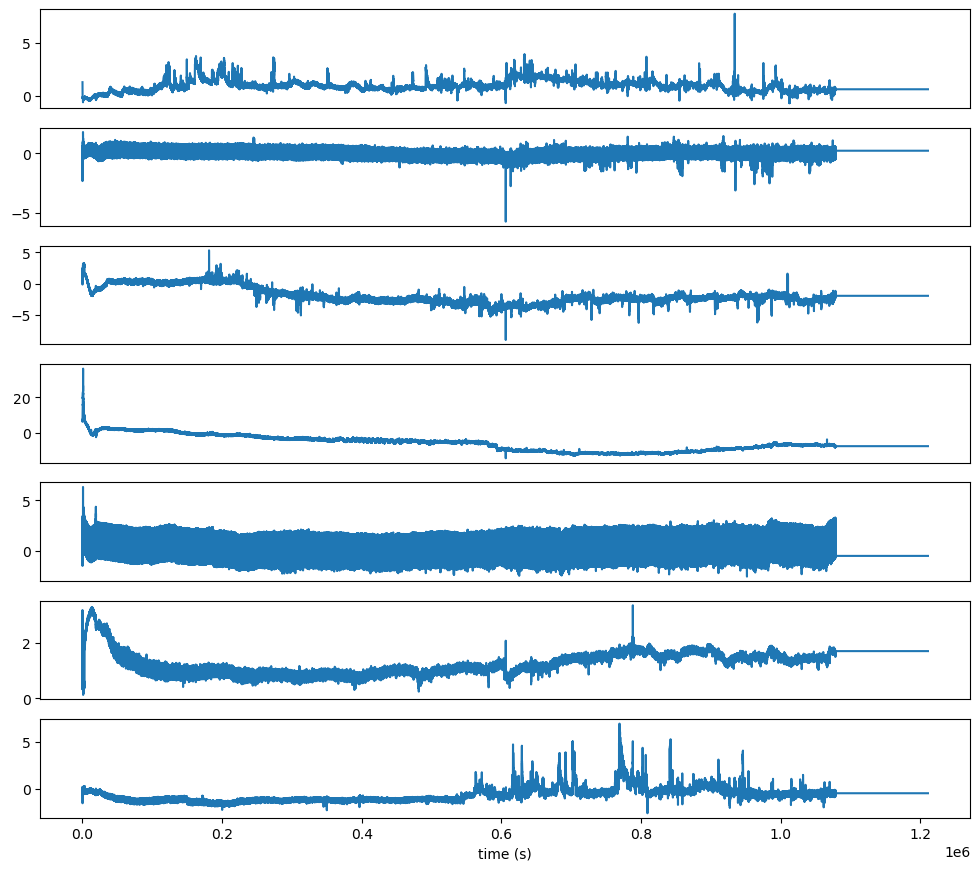

In [104]:
# plot each channel
time = np.arange(len(data)) / FS

fig, ax = plt.subplots(N_CHANNELS, 1, figsize=(12, N_CHANNELS*1.5))
for i in range(N_CHANNELS):
    ax[i].plot(time, data.iloc[:, i])
    if i < N_CHANNELS-1:
        ax[i].set(xticks=[], xlabel='')

ax[N_CHANNELS-1].set(xlabel='time (s)');

### detect spikes
apply low pass filter, find epochs above threshold

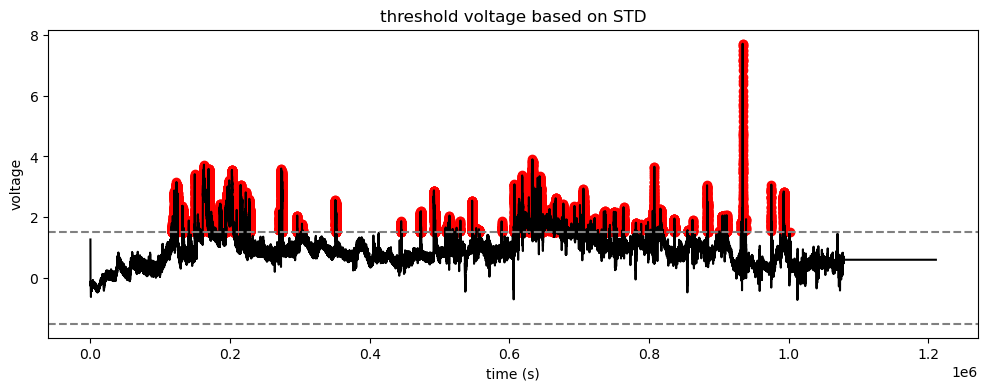

In [116]:
# simple threshold

# example cahnnel
i_chan = 0
sig = data.iloc[:, i_chan].values

# set threshold
thresh = np.std(sig) * 3

fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(time, sig, color='k')
ax.scatter(time[sig>thresh], sig[sig>thresh], color='r')
ax.scatter(time[sig<-thresh], sig[sig<-thresh], color='r')
ax.axhline(thresh, linestyle='--', color='grey')
ax.axhline(-thresh, linestyle='--', color='grey')
ax.set(xlabel="time (s)", ylabel="voltage")
ax.set_title("threshold voltage based on STD")
plt.show()

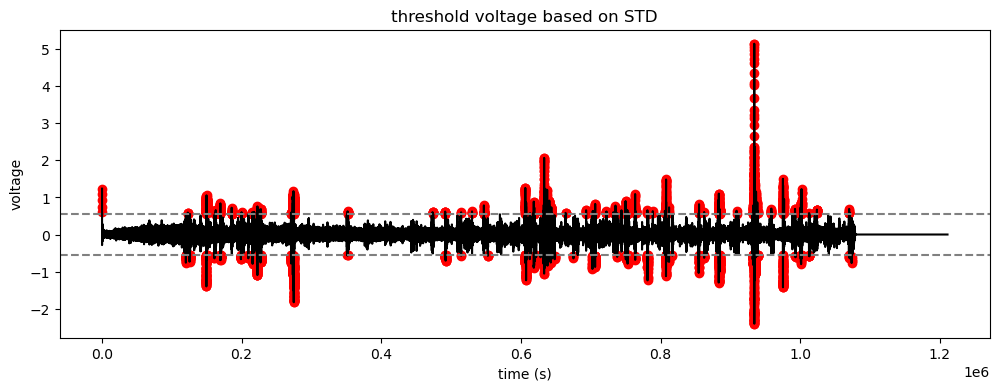

In [117]:
# highpass filter, then threshold

# filter signal
signal_filt = signal.sosfilt(signal.butter(10, 0.001, 'high', fs=FS, output='sos'), sig)

# set threshold
thresh = np.std(signal_filt) * 5

fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(time, signal_filt, color='k')
ax.scatter(time[signal_filt>thresh], signal_filt[signal_filt>thresh], color='r')
ax.scatter(time[signal_filt<-thresh], signal_filt[signal_filt<-thresh], color='r')
ax.axhline(thresh, linestyle='--', color='grey')
ax.axhline(-thresh, linestyle='--', color='grey')
ax.set(xlabel="time (s)", ylabel="voltage")
ax.set_title("threshold voltage based on STD")
plt.show()

Identified 1127 epochs
Joined 461 / 1127 epochs
Joined 872 / 1127 epochs
Dropped 397 / 666 epochs
Dropped 33 / 255 epochs
Identified 1069 epochs
Joined 471 / 1069 epochs
Joined 821 / 1070 epochs
Dropped 350 / 598 epochs
Dropped 46 / 249 epochs


(<Figure size 2000x400 with 1 Axes>, <AxesSubplot:>)

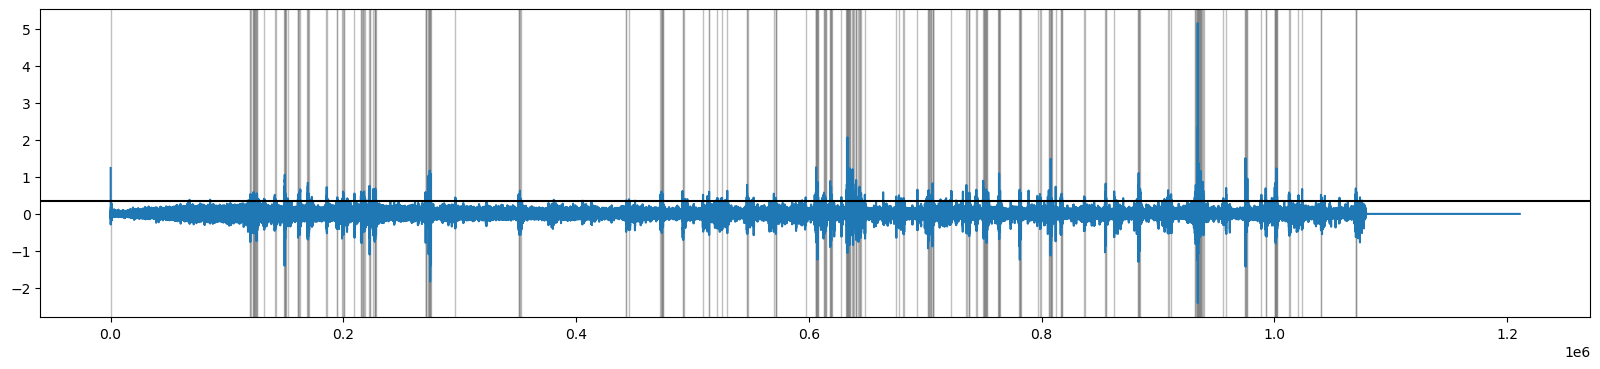

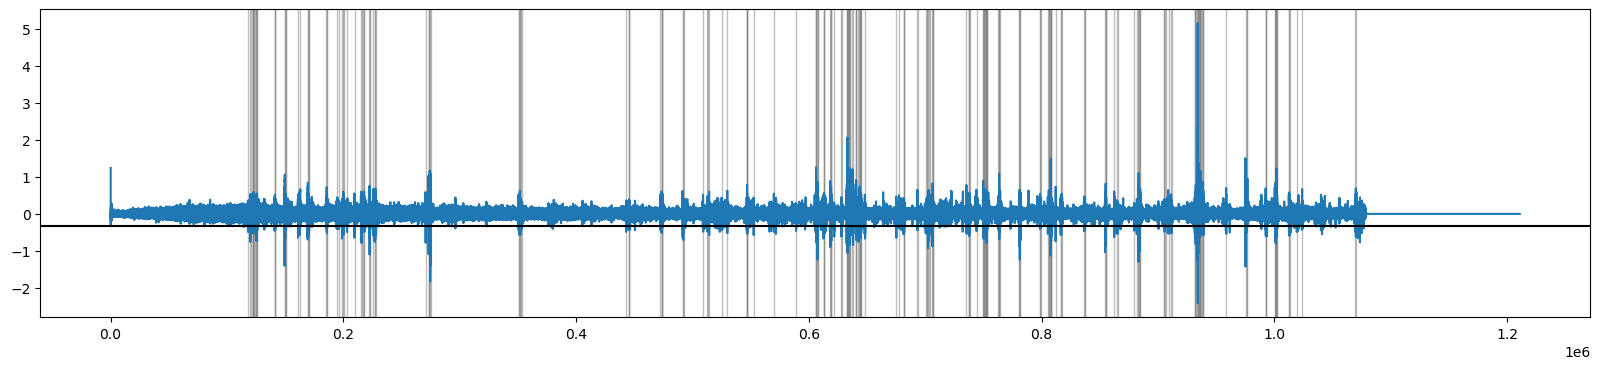

In [118]:
# find epochs
thresh = np.std(signal_filt) * 3
# epochs_pos = get_epochs(signal_filt, thresh)
# epochs_neg = get_epochs(-signal_filt, thresh)
epochs_pos,_ = get_epoch_times(signal_filt, thresh, min_gap=10, min_duration=10)
epochs_neg,_ = get_epoch_times(-signal_filt, thresh, min_gap=10, min_duration=10)

# plot
plot_epochs(signal_filt, time, epochs_pos, thresh)
plot_epochs(signal_filt, time, epochs_neg, -thresh)

### Plot results

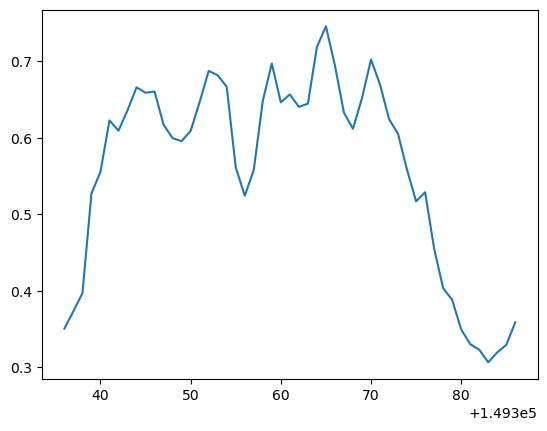

In [119]:
# plot example spikes
i_epoch = 19
plt.plot(time[epochs_pos[i_epoch][0]:epochs_pos[i_epoch][1]], signal_filt[epochs_pos[i_epoch][0]:epochs_pos[i_epoch][1]])

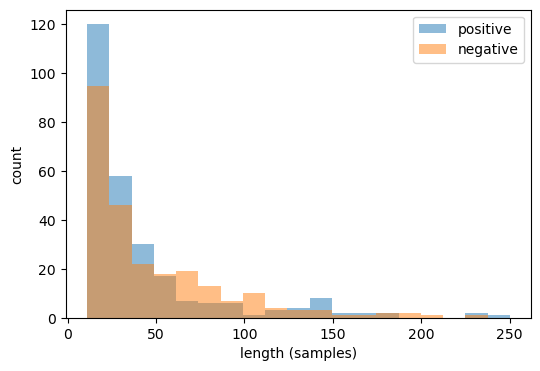

In [120]:
# compute duration of each spikes and plot histogram of results

# compute duration
lengths_pos = [epoch[1]-epoch[0] for epoch in epochs_pos]
lengths_neg = [epoch[1]-epoch[0] for epoch in epochs_neg]

# plot results
fig, ax = plt.subplots(1,1, figsize=[6,4])
all_values = np.concatenate([lengths_pos, lengths_neg])
bin_edges = np.linspace(np.min(all_values), np.max(all_values), 20)
ax.hist(lengths_pos, bin_edges, alpha=0.5, label='positive')
ax.hist(lengths_neg, bin_edges, alpha=0.5, label='negative')
ax.set(xlabel="length (samples)", ylabel="count")
ax.legend()
plt.show()

plotting 240 samples


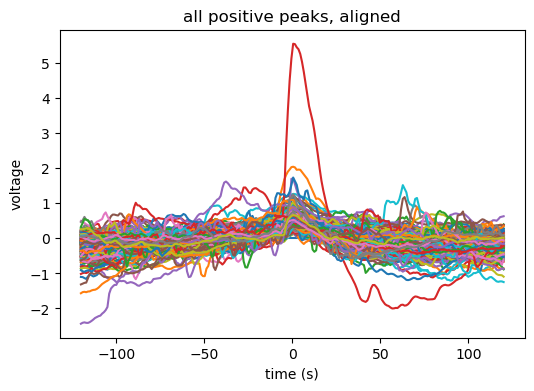

In [112]:
# plot all positive spikes, aligned at peak

# n_samples = int(np.median(lengths_pos))
# n = np.floor(n_samples/2)
n = 120
print(f"plotting {int(n*2)} samples")

# find peak of each spikes
peak_idx = []
for i_epoch, epoch in enumerate(epochs_pos):
    peak_idx.append(epoch[0] + np.argmax(signal_filt[epoch[0]:epoch[1]]))

# get signal around peak
peaks_array = np.zeros([len(peak_idx), int(n*2)])
for i_peak, idx in enumerate(peak_idx):
    if idx-n < 0: continue
    peaks_array[i_peak] = signal_filt[int(idx-n):int(idx+n)]

# subtract mean
peaks_array_bl = np.zeros_like(peaks_array)
for ii in range(len(peaks_array)):
    peaks_array_bl[ii] = peaks_array[ii] - np.mean(peaks_array[ii])

# plot
time_peak = np.linspace(-n*FS, n*FS, peaks_array.shape[1])
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(time_peak, peaks_array_bl.T)
ax.set(xlabel="time (s)", ylabel="voltage")
ax.set_title("all positive peaks, aligned")
plt.show() 

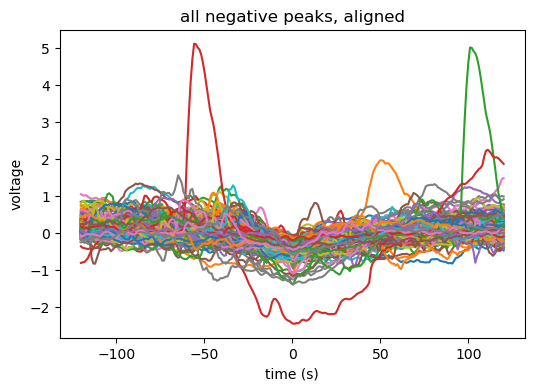

In [113]:
# plot all negative spikes

# find peak of each spikes
peak_idx = []
for i_epoch, epoch in enumerate(epochs_neg):
    peak_idx.append(epoch[0] + np.argmin(signal_filt[epoch[0]:epoch[1]]))
peak_idx

# get data
peaks_array = np.zeros([len(peak_idx), int(n*2)])
for i_peak, idx in enumerate(peak_idx):
    if idx-n < 0: continue
    peaks_array[i_peak] = signal_filt[int(idx-n):int(idx+n)]

# subtract mean
peaks_array_bl = np.zeros_like(peaks_array)
for ii in range(len(peaks_array)):
    peaks_array_bl[ii] = peaks_array[ii] - np.mean(peaks_array[ii])

# plot
time_peak = np.linspace(-n*FS, n*FS, peaks_array.shape[1])
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(time_peak, peaks_array_bl.T)
ax.set(xlabel="time (s)", ylabel="voltage")
ax.set_title("all negative peaks, aligned")
plt.show() 

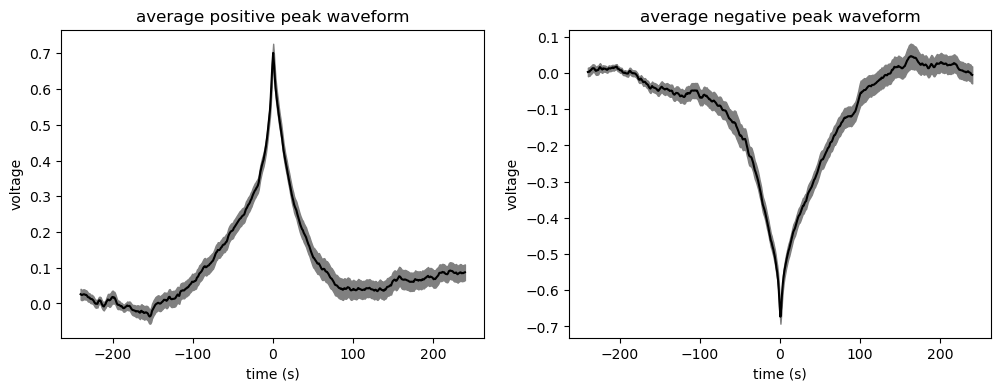

In [114]:
# plot avergae waveform for positive and negative spikes

n = 240

# find peak of each spikes
idx_n = []
for i_epoch, epoch in enumerate(epochs_neg):
    idx_n.append(epoch[0] + np.argmin(signal_filt[epoch[0]:epoch[1]]))
idx_p = []
for i_epoch, epoch in enumerate(epochs_pos):
    idx_p.append(epoch[0] + np.argmax(signal_filt[epoch[0]:epoch[1]]))

# get data
array_p = np.zeros([len(idx_p), int(n*2)])
for i_peak, idx in enumerate(idx_p):
    if idx-n < 0: continue
    array_p[i_peak] = signal_filt[int(idx-n):int(idx+n)]
array_n = np.zeros([len(idx_n), int(n*2)])
for i_peak, idx in enumerate(idx_n):
    if idx-n < 0: continue
    array_n[i_peak] = signal_filt[int(idx-n):int(idx+n)]

# subtract mean
for ii in range(len(array_p)):
    array_p[ii] = array_p[ii] - np.mean(array_p[ii, :int(n/3)])
for ii in range(len(array_n)):
    array_n[ii] = array_n[ii] - np.mean(array_n[ii, :int(n/3)])

# plot
time_peak = np.linspace(-n*FS, n*FS, array_p.shape[1])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,4])
for ax, array, tag in zip([ax1, ax2], [array_p, array_n], 
                            ['positive', 'negative']):
    mean = np.mean(array, axis=0)
    sem = np.std(array, axis=0) / np.sqrt(array.shape[0])
    ax.fill_between(time_peak, mean-sem, mean+sem, color='grey')
    ax.plot(time_peak, mean, color='k')
    ax.set(xlabel="time (s)", ylabel="voltage")
    ax.set_title(f"average {tag} peak waveform")
plt.show() 

In [132]:
# compute some quick spike stats
all_peaks = np.sort(np.concatenate([idx_p, idx_n]))
n_spikes = len(all_peaks)
spike_rate = n_spikes / time[-1]
isi = np.diff(all_peaks) / FS
mean_isi = np.mean(isi)
mean_duration = np.mean(np.concatenate([lengths_pos, lengths_neg])) * FS

print(f"Total number of spikes: \t{n_spikes}")
print(f"Mean duration: \t\t\t{mean_duration:0.2f} seconds")
print(f"Mean inter-spike interval: \t{mean_isi:.0f} seconds (i.e. {mean_isi/60:0.2f} minutes)")

Total number of spikes: 	517
Mean duration: 			43.95 seconds
Mean inter-spike interval: 	2075 seconds (i.e. 34.58 minutes)
